In [13]:
import itertools
import numpy as np
import networkx as nx
import sys
sys.path.append('./../')
from src.datamanager import read_data
from matplotlib import pyplot as plt
import pickle
import MQLib
import qiskit_ionq
from time import time
from src.newgraph import RandomGraphs


In [14]:
def get_prob_distribution(dict):
    size_dict = np.sum(np.array([dict[i] for i in dict]))
    probs = [dict[i]/size_dict for i in dict]
    return probs

def dictionary_aggregator(dict_1, dict_2):
    final_dict = {}
    for i in dict_1:
        final_dict[i] = dict_1[i]
    for j in dict_2:
        if j in final_dict:
            final_dict[j] = final_dict[j]+(dict_2[j])
        else:
            final_dict[j] = (dict_2[j])
    return final_dict

def dictionary_aggregator_partial(dict_1, dict_2, shots_2):
    new_dict_2 = {}

    for i in np.random.choice(list(dict_2.keys()), size = shots_2, p=get_prob_distribution(dict_2)):
        new_dict_2[i] = dict_2[i]

    final_dict = {}
    for i in dict_1:
        final_dict[i] = dict_1[i]
    for j in new_dict_2:
        if j in final_dict:
            final_dict[j] = final_dict[j]+(new_dict_2[j])
        else:
            final_dict[j] = (new_dict_2[j])
    return final_dict

def probability_to_counts(dict, shots):
    final_dict = {}
    for i in dict:
        final_dict[i] = dict[i]*shots
    return final_dict


def expectations_from_counts(nqubits, counts, shots, lower_order_terms, pauli_word_order):
    expectations = []
    new_counts = {}

    for i in list(counts):
        new_counts[f'{int(i,2):0{nqubits}b}'] = counts[i]

    for i in range(lower_order_terms, pauli_word_order + 1):
        for gate_indices in list(itertools.combinations(list(range(nqubits)), i)):
            single_expect = 0
            for bitstring in new_counts.keys():
                sign = -1
                obs = [bitstring[j] for j in gate_indices]
                if obs.count('1') % 2 == 0:
                    sign = 1
                single_expect += sign * new_counts[bitstring] / shots

            expectations.append(single_expect)
    return expectations
def _round(num: float) -> int:
    np.random.seed(0)
    if num > 0:
        return +1
    elif num < 0:
        return -1
    else:
        return np.random.choice([-1, 1], 1)[0]

def graph_to_dict_quadratic(graph):
    """
    Function that, given a graph, return a dictionary of the edges and the maximum eigenvalue of the
    adjacency matrix.
    :param graph: A nx graph.
    :return: A dictionary of the edges and the maximum eigenvalue of the adjacency matrix.
    """
    edges = dict()
    for i in graph.edges(data=True):
        edges[(int(i[0]), int(i[1]))] = i[2]['weight']
    return edges

def graph_to_dict(graph):
    adj_matrix = nx.to_numpy_array(graph)
    edges = {}
    for i in range(adj_matrix.shape[0]):
        for j in range(i):
            if adj_matrix[i][j] == 0:
                continue
            edges[(i, j)] = adj_matrix[i][j]
    return edges

def _get_exact_solution(graph, seed, time_compute=0.5, full_result=False):
    """
    Function that, given a graph, return either the exact maxcut solution, or the one found by BURER heuristic
    :param instance: istance index number
    :param graph: graph to find the maxcut
    :return:
    """
    np.random.seed(int(time()))
    instance = MQLib.Instance('M', nx.to_numpy_array(graph))
    def cb_fun(spins):
        #print("New solution = %s" % spins)
        return 1
    result = MQLib.runHeuristic('BURER2002', instance, time_compute, cb_fun,seed=seed)
    max_energy = result['objval']
    result_exact = [(max_energy, 0)]
    if full_result:
        return result
    else:
        return result_exact
def _loss_MBE( expects, qubits, adjacency_matrix, num_vertices, hyperparameters):
    """
    Function that evaluate the loss function
    :param adjacency_matrix: adjacency matrix of the graph to cut

    :return: value of the loss
    """
    loss = 0
    node_mapping_expectation = expects
    for i in adjacency_matrix:
        loss = loss + adjacency_matrix[i] * np.tanh(
            node_mapping_expectation[i[0]] * hyperparameters[0] * qubits) \
               * np.tanh(node_mapping_expectation[i[1]] * hyperparameters[0] * qubits)

    penalization = 0
    for i in range(num_vertices):
        penalization = penalization + np.tanh(node_mapping_expectation[i] * hyperparameters[0] * qubits) ** 2
    penalization = (len(adjacency_matrix) / 2 + (num_vertices - 1) / 4) * (penalization / num_vertices) ** 2 * \
                   hyperparameters[1]
    return loss + penalization
def expectations_from_counts_quadratic(nqubits, counts, shots, lower_order_terms, pauli_word_order):
    expectations = []
    new_counts = {}

    for i in list(counts):
        new_counts[f'{int(i,2):0{nqubits}b}'] = counts[i]

    for i in range(lower_order_terms, pauli_word_order + 1):
        for gate_indices in list(itertools.combinations(list(range(nqubits)), i)):
            single_expect = 0
            for bitstring in new_counts.keys():
                sign = -1
                obs = [bitstring[j] for j in gate_indices]
                if obs.count('1') % 2 == 0:
                    sign = 1
                single_expect += sign * new_counts[bitstring] / shots

            expectations.append(single_expect)
    map = [0, 1, 2, 3, 4, 240, 241, 242, 243, 244, 245, 168, 169, 170, 171, 172, 173, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 246, 247, 248, 249, 250, 251, 174, 175, 176, 177, 178, 179, 15, 16, 17, 18, 19, 20, 21, 22, 23, 252, 253, 254, 255, 256, 257, 180, 181, 182, 183, 184, 185, 24, 25, 26, 27, 28, 29, 30, 31, 258, 259, 260, 261, 262, 263, 186, 187, 188, 189, 190, 191, 32, 33, 34, 35, 36, 37, 38, 264, 265, 266, 267, 268, 269, 192, 193, 194, 195, 196, 197, 39, 40, 41, 42, 43, 44, 270, 271, 272, 273, 274, 275, 198, 199, 200, 201, 202, 203, 45, 46, 47, 48, 49, 50, 66, 67, 68, 69, 70, 204, 205, 206, 207, 208, 209, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 210, 211, 212, 213, 214, 215, 81, 82, 83, 84, 85, 86, 87, 88, 89, 216, 217, 218, 219, 220, 221, 90, 91, 92, 93, 94, 95, 96, 97, 222, 223, 224, 225, 226, 227, 98, 99, 100, 101, 102, 103, 104, 228, 229, 230, 231, 232, 233, 105, 106, 107, 108, 109, 110, 234, 235, 236, 237, 238, 239, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
    obs = np.zeros(len(expectations))
    for i in range(len(obs)):
        obs[map[i]] = expectations[i]
    expectations = obs.tolist()
    return expectations
def random_cut_estimator(nodes, adjacency_matrix):
    cut_value = []
    for i in range(1000):
        cut_value.append(_cut_value(np.random.choice([-1,1], size=nodes), adjacency_matrix))
    return np.mean(np.array(cut_value)), np.std(np.array(cut_value))
def random_cut_estimator_swap(nodes, adjacency_matrix):
    cut_value = [_one_flip(adjacency_matrix,np.random.choice([-1,1], size=nodes))[0]]
    for i in range(100):
        final_cut = _one_flip(adjacency_matrix,np.random.choice([-1,1], size=nodes))[0]
        cut_value.append(final_cut)
    return np.mean(np.array(cut_value)), np.std(np.array(cut_value))
def _value_edge(x1,x2, edge):
    return edge * (1 - x1 * x2) / 2

def _cut_value(node_mapping_expectation, adjacency_matrix) -> float:
    cut_value = 0
    for i in adjacency_matrix:
        cut_value += _value_edge(node_mapping_expectation[i[0]],node_mapping_expectation[i[1]], adjacency_matrix[i]) 
    return cut_value

def _update_cut( edges_dict, cut_to_update,adjacency_matrix):
    for j in edges_dict:
        cut_to_update -= _value_edge(edges_dict[j][0],edges_dict[j][1], adjacency_matrix[j])
        cut_to_update += _value_edge(-edges_dict[j][0],edges_dict[j][1], adjacency_matrix[j])
    return cut_to_update
        
def get_other_element(my_tuple, given_element):
    if my_tuple[0] == given_element:
        return my_tuple[1]
    elif my_tuple[1] == given_element:
        return my_tuple[0]  
    
def _one_flip(adj_matrix, starting_solution):
    starting_cut = _cut_value(starting_solution, adj_matrix)
    best_cut = starting_cut
    best_solution = starting_solution.copy()
    for i in range(len(starting_solution)+1):
        temporary_solution = best_solution.copy()
        edges_list = {j:(temporary_solution[i],temporary_solution[get_other_element(j,i)] ) for j in adj_matrix.keys() if i in j }
        new_cut = _update_cut(edges_list,best_cut, adj_matrix)
        if new_cut > best_cut:
            temporary_solution[i] = -1 * temporary_solution[i] 
            best_solution =  temporary_solution.copy()
            best_cut = new_cut
        
    return _cut_value(best_solution, adj_matrix), best_solution

# 800 cubic

In [32]:
with open('shots_z_20230705-191710.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230705-191710.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230705-191710.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230706-105312.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230706-105312.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230706-105312.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230706-141224.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230706-141224.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230706-141224.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
with open('shots_z_20230706-142626.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230706-142626.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230706-142626.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230706-154626.pkl', 'rb') as f:
    file_z_5 = pickle.load(f).get_counts()
with open('shots_x_20230706-154626.pkl', 'rb') as f:
    file_x_5 = pickle.load(f).get_counts()
with open('shots_y_20230706-154626.pkl', 'rb') as f:
    file_y_5 = pickle.load(f).get_counts()
with open('shots_z_20230706-161445.pkl', 'rb') as f:
    file_z_6 = pickle.load(f).get_counts()
with open('shots_x_20230706-161445.pkl', 'rb') as f:
    file_x_6 = pickle.load(f).get_counts()
with open('shots_y_20230706-161445.pkl', 'rb') as f:
    file_y_6 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G1')
adjacency_matrix =graph_to_dict(graph)
cut_800_cubic = []
file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2, 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4,'file_z_5':file_z_5, 'file_x_5':file_x_5, 'file_y_5':file_y_5, 'file_z_6':file_z_6, 'file_x_6':file_x_6, 'file_y_6':file_y_6}
for j in range(100,7100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []

    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(13, i, j, 3, 3)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    final_cut = _one_flip( adjacency_matrix, solution)[0]
    cut_800_cubic.append(final_cut)
print(cut_800_cubic)

/tmp/ipykernel_26238/2360799556.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2360799556.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2360799556.py:6: DeprecationWarni

[10956.0, 10946.0, 10990.0, 10971.0, 10992.0, 11007.0, 10974.0, 10980.0, 11042.0, 11027.0, 11049.0, 11068.0, 11044.0, 11082.0, 11117.0, 11048.0, 11092.0, 11035.0, 11077.0, 11072.0, 11130.0, 11116.0, 11133.0, 11159.0, 11094.0, 11116.0, 11124.0, 11126.0, 11151.0, 11122.0, 11177.0, 11162.0, 11157.0, 11097.0, 11123.0, 11143.0, 11121.0, 11160.0, 11196.0, 11154.0, 11147.0, 11124.0, 11161.0, 11217.0, 11158.0, 11147.0, 11137.0, 11171.0, 11201.0, 11153.0, 11194.0, 11183.0, 11132.0, 11161.0, 11150.0, 11163.0, 11159.0, 11207.0, 11162.0, 11157.0, 11130.0, 11168.0, 11174.0, 11174.0, 11156.0, 11132.0, 11162.0, 11130.0, 11153.0, 11128.0]


# 800 quadratic

In [31]:
with open('shots_z_20230707-163347.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230707-163347.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230707-163347.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230707-170708.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230707-170708.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230707-170708.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230707-161202.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230707-161202.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230707-161202.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230711-104733.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230711-104733.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230711-104733.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G1')
adjacency_matrix =graph_to_dict_quadratic(graph)

cut_800_quadratic = []

file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2 , 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4}
for j in range(100,4100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts_quadratic(24, i, j, 2, 2)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    final_cut = _one_flip( adjacency_matrix, solution)[0]
    cut_800_quadratic.append(final_cut)

/tmp/ipykernel_26238/977503388.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_4 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/977503388.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_4 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/977503388.py:6: DeprecationWarning:

# 2000 cubic IonQ

In [17]:
with open('shots_z_20230621-151212.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230621-151212.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230621-151212.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230621-154725.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230621-154725.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230621-154725.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230621-165012.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230621-165012.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230621-165012.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
with open('shots_z_20230621-230400.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230621-230400.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230621-230400.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230622-155619.pkl', 'rb') as f:
    file_z_5 = pickle.load(f).get_counts()
with open('shots_x_20230622-155619.pkl', 'rb') as f:
    file_x_5 = pickle.load(f).get_counts()
with open('shots_y_20230622-155619.pkl', 'rb') as f:
    file_y_5 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G35')
adjacency_matrix=graph_to_dict(graph)
cut_2000_cubic = []

file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2, 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4,'file_z_5':file_z_5, 'file_x_5':file_x_5, 'file_y_5':file_y_5}
for j in range(100,5100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(17, i, j, 3, 3)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    final_cut = _one_flip( adjacency_matrix, solution)[0]
    cut_2000_cubic.append(final_cut)


/tmp/ipykernel_26238/2092001778.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2092001778.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2092001778.py:6: DeprecationWarni

/tmp/ipykernel_26238/2992330342.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(list(range(100,4100,100)), np.array(cut_800_quadratic)/11624, 'o', label=r'800 quadratic',markersize=4, color='#ff9f9b', marker = "^")
/tmp/ipykernel_26238/2992330342.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(list(range(100,7100,100)), np.array(cut_800_cubic)/11624, 'o',markersize=4, color='#ff9f9b', label=r'800 cubic ',marker = "x" )
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


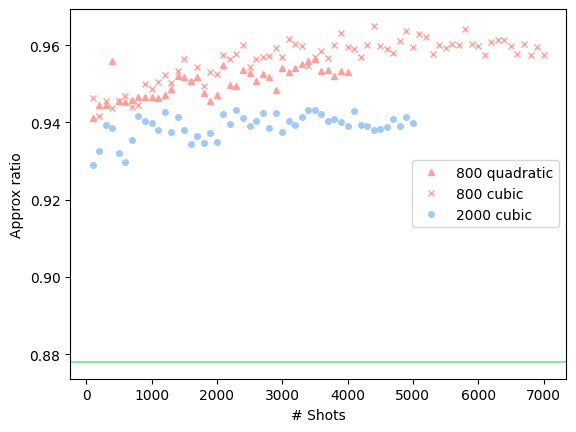

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')
plt.plot(list(range(100,4100,100)), np.array(cut_800_quadratic)/11624, 'o', label=r'800 quadratic',markersize=4, color='#ff9f9b', marker = "^")
plt.plot(list(range(100,7100,100)), np.array(cut_800_cubic)/11624, 'o',markersize=4, color='#ff9f9b', label=r'800 cubic ',marker = "x" )
plt.plot(list(range(100,5100,100)), np.array(cut_2000_cubic)/7687, 'o', label=r'2000 cubic',markersize=4, color='#a1c9f4')


plt.axhline(y=0.878, color='#8de5a1')
plt.xlabel('# Shots')
plt.ylabel('Approx ratio')
plt.legend()
plt.savefig('regular_maxcut_comparison.eps',dpi=300, bbox_inches = "tight",  format='eps')
plt.show()



# 2000 cubic IonQ


In [18]:
with open('results_1400shots', 'rb') as f:
    file = pickle.load(f)
file_z_1 = dict(file[1])
dict_file_z_1 = {''.join(map(str,i))[::-1]:file_z_1[i] for i in file_z_1}
file_z_1 = dict_file_z_1
file_x_1 = dict(file[0])
dict_file_x_1 = {''.join(map(str,i))[::-1]:file_x_1[i] for i in file_x_1}
file_x_1 = dict_file_x_1
file_y_1 = dict(file[2])
dict_file_y_1 = {''.join(map(str,i))[::-1]:file_y_1[i] for i in file_y_1}
file_y_1 = dict_file_y_1

with open('results_5600shots', 'rb') as f:
    file = pickle.load(f)
file_z_2 = dict(file[1])
dict_file_z_2 = {''.join(map(str,i))[::-1]:file_z_2[i] for i in file_z_2}
file_z_2 = dict_file_z_2
file_x_2 = dict(file[0])
dict_file_x_2 = {''.join(map(str,i))[::-1]:file_x_2[i] for i in file_x_2}
file_x_2 = dict_file_x_2
file_y_2 = dict(file[2])
dict_file_y_2 = {''.join(map(str,i))[::-1]:file_y_2[i] for i in file_y_2}
file_y_2 = dict_file_y_2


graph = nx.read_weighted_edgelist('G35')
adjacency_matrix=graph_to_dict(graph)
cut_2000_cubic_quantinuum = []
file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1, 'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2}

for j in range(100,7100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp, file_x_exp, file_y_exp]:
        data = expectations_from_counts(17, i, j, 3, 3)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    final_cut = _one_flip( adjacency_matrix, solution)[0]
    cut_2000_cubic_quantinuum.append(final_cut)

# Loss 800 quadratic

In [21]:
with open('shots_z_20230707-163347.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230707-163347.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230707-163347.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230707-170708.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230707-170708.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230707-170708.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230707-161202.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230707-161202.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230707-161202.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230711-104733.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230711-104733.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230711-104733.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G1')
adjacency_matrix =graph_to_dict_quadratic(graph)

noiseless_loss_800_quadratic = []
for i in range(100,4100,100):
    noiseless_loss_shot = []
    for j in range(10):
        data = read_data('experiment_800_noiseless_quadratic', 'experiment_800_noiseless_quadratic', ['unrounded_solution'], {'epochs':i, 'trial': j})
        stuff = data[0][0].replace("\n","").replace("[",'').replace(']','').replace(',', ' ')
        x = np.array(stuff.split())
        y = x.astype(float)
        noiseless_loss_shot.append(_loss_MBE( y, 24, adjacency_matrix,800, [1.5, 0.1]))
    noiseless_loss_800_quadratic.append(np.mean(noiseless_loss_shot))


loss_800_quadratic = []


file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2 , 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4}
for j in range(100,4100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts_quadratic(24, i, j, 2, 2)
        expectations = expectations+data

    loss_800_quadratic.append(_loss_MBE(expectations, 24, adjacency_matrix, 800, [1.5, 0.1]))

/tmp/ipykernel_26238/1730249409.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_4 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/1730249409.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_4 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/1730249409.py:6: DeprecationWarni

-1.131466263573579
-0.857369771044348
-1.4973335817827917
-1.3193998356278276
-1.3856657017437903
-2.4261102836185016
-1.5341983598897269
-0.986783685735643
-0.9881081487042042
-0.9378163351778124
-1.074649040352657
-0.8303744912407446
-1.0704096285620868
-1.0193429752657703
-0.8643216005494486
-1.0434888607990525
-0.7025901471850248
-0.7901228968712015
-0.8023971131233083
-0.7905530667454176
-0.5830918593791079
-0.6250138192472355
-0.6325400833140483
-0.6884395209785638
-0.7323433851617707
-0.7583274634005143
-0.5405634361167644
-0.5404916499882829
-0.6344743991952685
-0.7072890663998401
-0.5732949471663261
-0.5626401510459293
-0.6074153521424416
-0.6104362570227152
-0.5873939552311949
-0.5753567793869407
-0.5494817971859792
-0.6056273685363631
-0.5417232237056803
-0.596290143607169
-0.5790889256086593
-0.5513303579512653
-0.5725357365470388
-0.5176799062897134
-0.5388806187216396
-0.5985599347096966
-0.5138992154650501
-0.5227122117047467
-0.5073564093589584
-0.5244460080894033
-0.47

# Loss 800 cubic


In [23]:
with open('shots_z_20230705-191710.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230705-191710.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230705-191710.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230706-105312.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230706-105312.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230706-105312.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230706-141224.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230706-141224.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230706-141224.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
with open('shots_z_20230706-142626.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230706-142626.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230706-142626.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230706-154626.pkl', 'rb') as f:
    file_z_5 = pickle.load(f).get_counts()
with open('shots_x_20230706-154626.pkl', 'rb') as f:
    file_x_5 = pickle.load(f).get_counts()
with open('shots_y_20230706-154626.pkl', 'rb') as f:
    file_y_5 = pickle.load(f).get_counts()
with open('shots_z_20230706-161445.pkl', 'rb') as f:
    file_z_6 = pickle.load(f).get_counts()
with open('shots_x_20230706-161445.pkl', 'rb') as f:
    file_x_6 = pickle.load(f).get_counts()
with open('shots_y_20230706-161445.pkl', 'rb') as f:
    file_y_6 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G1')
adjacency_matrix =graph_to_dict(graph)



noiseless_loss_800_cubic = []
for i in range(100,7100,100):
    noiseless_loss_shot = []
    for j in range(10):
        data = read_data('experiment_800_noiseless_qubic', 'experiment_800_noiseless_qubic', ['unrounded_solution'], {'epochs':i, 'trial': j})
        stuff = data[0][0].replace("\n","").replace("[",'').replace(']','').replace(',', ' ')
        x = np.array(stuff.split())
        y = x.astype(float)
        noiseless_loss_shot.append(_loss_MBE( y, 13, adjacency_matrix,800, [3, 0.1]))
    noiseless_loss_800_cubic.append(np.mean(noiseless_loss_shot))
loss_800_cubic = []

file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2, 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4,'file_z_5':file_z_5, 'file_x_5':file_x_5, 'file_y_5':file_y_5, 'file_z_6':file_z_6, 'file_x_6':file_x_6, 'file_y_6':file_y_6}
for j in range(100,7100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []

    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(13, i, j, 3, 3)
        expectations = expectations+data
    loss_800_cubic.append(_loss_MBE(expectations, 13, adjacency_matrix, 800, [3, 0.1]))

/tmp/ipykernel_26238/2501857614.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2501857614.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/2501857614.py:6: DeprecationWarni

-1.681503896860132
-3.045224142202887
-1.528863881897589
-1.5537768839556092
-1.5268606308066879
-1.9708776293132604
-1.824071630770231
-2.192698923230535
-3.383588083059654
-2.3676042524241847
-0.9324089218601935
-1.7395443008212554
-1.4117637780449648
-0.8695456513085965
-1.157261092663419
-0.8472932937054821
-0.7069707928260345
-1.2747235022885306
-1.2011200807506022
-1.2065025089798722
-0.7903469541245944
-0.8734841395332377
-1.1497555235626151
-1.18095437452934
-1.084120146539886
-0.924886813898856
-0.8030919890807453
-0.6857767539239679
-0.7259821851420868
-0.9197778745511547
-0.7919168059492638
-0.5726837128257046
-0.7880264576673826
-0.663588708008477
-0.5996908597064257
-0.585168634445496
-0.5478171789268627
-0.6952325662023021
-0.7380197879770724
-0.90298046388898
-0.6095514512512481
-0.6620299283614943
-0.6458010991335345
-0.5791723286574458
-0.5569867892715036
-0.4840208743470183
-0.5152397976077088
-0.6060362873826841
-0.5698282671588661
-0.7476138301592651
-0.511123564374

# Loss 2000 cubic

In [24]:
with open('shots_z_20230621-151212.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230621-151212.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230621-151212.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230621-154725.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230621-154725.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230621-154725.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230621-165012.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230621-165012.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230621-165012.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
with open('shots_z_20230621-230400.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230621-230400.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230621-230400.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230622-155619.pkl', 'rb') as f:
    file_z_5 = pickle.load(f).get_counts()
with open('shots_x_20230622-155619.pkl', 'rb') as f:
    file_x_5 = pickle.load(f).get_counts()
with open('shots_y_20230622-155619.pkl', 'rb') as f:
    file_y_5 = pickle.load(f).get_counts()
    
graph = nx.read_weighted_edgelist('G35')
adjacency_matrix=graph_to_dict(graph)


noiseless_loss_2000 = []
for i in range(100,4900,100):
    noiseless_loss_shot = []
    for j in range(10):
        data = read_data('experiment_2000_normalized_short', 'experiment_2000_normalized_short', ['unrounded_solution'], {'epochs':i, 'trial': j})
        stuff = data[0][0].replace("\n","").replace("[",'').replace(']','').replace(',', ' ')
        x = np.array(stuff.split())
        y = x.astype(float)
        noiseless_loss_shot.append(_loss_MBE( y, 17, adjacency_matrix,2000, [1.5, 0.3]))
    noiseless_loss_2000.append(np.mean(noiseless_loss_shot))


loss_2000 = []

file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2, 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4,'file_z_5':file_z_5, 'file_x_5':file_x_5, 'file_y_5':file_y_5}
for j in range(100,4900,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(17, i, j, 3, 3)
        expectations = expectations+data
    loss_2000.append(_loss_MBE(expectations, 17, adjacency_matrix, 2000, [1.5, 0.3]))

/tmp/ipykernel_26238/1258112243.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/1258112243.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/1258112243.py:6: DeprecationWarni

-3.7016558743993064
-3.684888266779985
-3.365865888195429
-4.362313107929283
-3.976173851023023
-3.542709835069563
-3.705964743716261
-11.433149212756382
-2.8865054100113205
-5.744173467176212
-1.6249272744795944
-2.0725007490420637
-2.486764264529701
-2.3112571931241725
-1.77061827892681
-1.6451432380154574
-1.536676396222717
-2.273402790821468
-1.7795487371577252
-1.8522888049206347
-1.3296802147372417
-1.3251456422821801
-1.8769463305084289
-1.4023668671581295
-1.770623216938602
-1.5551910644296607
-1.09966150515396
-1.9917886369836617
-1.5085940720311017
-1.6147029417496463
-0.989325426105265
-1.0551636890585327
-1.1048468798840292
-1.3162311924852335
-1.1761620779237174
-1.082052609237034
-0.9142894661432899
-1.4726397176265789
-1.1048620760661156
-1.2678611132076418
-0.8443281108431665
-0.8906976762997669
-0.9159786419704459
-0.9699616852194016
-0.9618514190469714
-0.916372331754527
-0.8414005184710156
-1.104702163673276
-0.8773712462759037
-1.0320751609073775
-0.7795312694102284

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


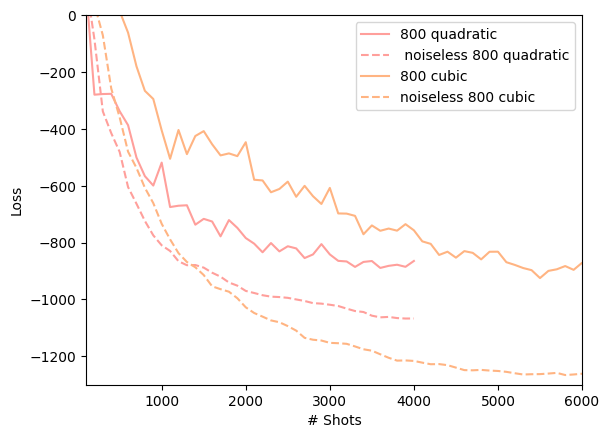

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')
plt.plot(list(range(100,4100,100)), np.array(loss_800_quadratic), '-', label=r'800 quadratic',markersize=4, color='#ff9f9b')
plt.plot(list(range(100,4100,100)), np.array(noiseless_loss_800_quadratic), '--', label=r' noiseless 800 quadratic',markersize=4, color='#ff9f9b')

plt.plot(list(range(100,7100,100)), np.array(loss_800_cubic), '-',markersize=4, color='#ffb482', label=r'800 cubic ' )
plt.plot(list(range(100,7100,100)), np.array(noiseless_loss_800_cubic), '--',markersize=4, color='#ffb482', label=r'noiseless 800 cubic ')


plt.ylim(-1300,0)
plt.xlim(100,6000)
plt.xlabel('# Shots')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_regular_maxcut_comparison.eps',dpi=300, bbox_inches = "tight",  format='eps')
plt.show()

# Combined image

In [25]:
with open('shots_z_20230608-123942.pkl', 'rb') as f:
    file_z_1 = pickle.load(f).get_counts()
with open('shots_x_20230608-123942.pkl', 'rb') as f:
    file_x_1 = pickle.load(f).get_counts()
with open('shots_y_20230608-123942.pkl', 'rb') as f:
    file_y_1 = pickle.load(f).get_counts()
with open('shots_z_20230608-140346.pkl', 'rb') as f:
    file_z_2 = pickle.load(f).get_counts()
with open('shots_x_20230608-140346.pkl', 'rb') as f:
    file_x_2 = pickle.load(f).get_counts()
with open('shots_y_20230608-140346.pkl', 'rb') as f:
    file_y_2 = pickle.load(f).get_counts()
with open('shots_z_20230608-151453.pkl', 'rb') as f:
    file_z_3 = pickle.load(f).get_counts()
with open('shots_x_20230608-151453.pkl', 'rb') as f:
    file_x_3 = pickle.load(f).get_counts()
with open('shots_y_20230608-151453.pkl', 'rb') as f:
    file_y_3 = pickle.load(f).get_counts()
with open('shots_z_20230608-153420.pkl', 'rb') as f:
    file_z_4 = pickle.load(f).get_counts()
with open('shots_x_20230608-153420.pkl', 'rb') as f:
    file_x_4 = pickle.load(f).get_counts()
with open('shots_y_20230608-153420.pkl', 'rb') as f:
    file_y_4 = pickle.load(f).get_counts()
with open('shots_z_20230609-012642.pkl', 'rb') as f:
    file_z_5 = pickle.load(f).get_counts()
with open('shots_x_20230609-012642.pkl', 'rb') as f:
    file_x_5 = pickle.load(f).get_counts()
with open('shots_y_20230609-012642.pkl', 'rb') as f:
    file_y_5 = pickle.load(f).get_counts()
with open('shots_z_20230711-120014.pkl', 'rb') as f:
    file_z_6 = pickle.load(f).get_counts()
with open('shots_x_20230711-120014.pkl', 'rb') as f:
    file_x_6 = pickle.load(f).get_counts()
with open('shots_y_20230711-120014.pkl', 'rb') as f:
    file_y_6 = pickle.load(f).get_counts()
graph = nx.read_weighted_edgelist('toruspm3-8-50')
adjacency_matrix=graph_to_dict(graph)

/tmp/ipykernel_26238/3869140669.py:2: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_z_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/3869140669.py:4: DeprecationWarning: The class ``qiskit.qobj.common.QobjDictField`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  file_x_1 = pickle.load(f).get_counts()
/tmp/ipykernel_26238/3869140669.py:6: DeprecationWarni

In [26]:
cut = []
file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2, 'file_z_3':file_z_3, 'file_x_3':file_x_3, 'file_y_3':file_y_3,'file_z_4':file_z_4, 'file_x_4':file_x_4, 'file_y_4':file_y_4,'file_z_5':file_z_5, 'file_x_5':file_x_5, 'file_y_5':file_y_5, 'file_z_6':file_z_6, 'file_x_6':file_x_6, 'file_y_6':file_y_6}
for j in range(100,6100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []

    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(19, i, j, 2, 2)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    cut.append(_one_flip( adjacency_matrix, solution)[0])

100
0.0
100
200
0.0
200
300
0.0
300
400
0.0
400
500
0.0
500
600
0.0
600
700
0.0
700
800
0.0
800
900
0.0
900
1000
0.0
1000
1100
1000
100
1200
1000
200
1300
1000
300
1400
1000
400
1500
1000
500
1600
1000
600
1700
1000
700
1800
1000
800
1900
1000
900
2000
1000
1000
2100
2000
100
2200
2000
200
2300
2000
300
2400
2000
400
2500
2000
500
2600
2000
600
2700
2000
700
2800
2000
800
2900
2000
900
3000
2000
1000
3100
3000
100
3200
3000
200
3300
3000
300
3400
3000
400
3500
3000
500
3600
3000
600
3700
3000
700
3800
3000
800
3900
3000
900
4000
3000
1000
4100
4000
100
4200
4000
200
4300
4000
300
4400
4000
400
4500
4000
500
4600
4000
600
4700
4000
700
4800
4000
800
4900
4000
900
5000
4000
1000
5100
5000
100
5200
5000
200
5300
5000
300
5400
5000
400
5500
5000
500
5600
5000
600
5700
5000
700
5800
5000
800
5900
5000
900
6000
5000
1000


In [34]:
with open('results_1400shots', 'rb') as f:
    file = pickle.load(f)
file_z_1 = dict(file[1])
dict_file_z_1 = {''.join(map(str,i))[::-1]:file_z_1[i] for i in file_z_1}
file_z_1 = dict_file_z_1
file_x_1 = dict(file[0])
dict_file_x_1 = {''.join(map(str,i))[::-1]:file_x_1[i] for i in file_x_1}
file_x_1 = dict_file_x_1
file_y_1 = dict(file[2])
dict_file_y_1 = {''.join(map(str,i))[::-1]:file_y_1[i] for i in file_y_1}
file_y_1 = dict_file_y_1

with open('results_5600shots', 'rb') as f:
    file = pickle.load(f)
file_z_2 = dict(file[1])
dict_file_z_2 = {''.join(map(str,i))[::-1]:file_z_2[i] for i in file_z_2}
file_z_2 = dict_file_z_2
file_x_2 = dict(file[0])
dict_file_x_2 = {''.join(map(str,i))[::-1]:file_x_2[i] for i in file_x_2}
file_x_2 = dict_file_x_2
file_y_2 = dict(file[2])
dict_file_y_2 = {''.join(map(str,i))[::-1]:file_y_2[i] for i in file_y_2}
file_y_2 = dict_file_y_2


graph = nx.read_weighted_edgelist('G35')
adjacency_matrix=graph_to_dict(graph)
cut_2000_cubic_quantinuum = []
file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1, 'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2}

for j in range(100,7100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp, file_x_exp, file_y_exp]:
        data = expectations_from_counts(17, i, j, 3, 3)
        expectations = expectations+data
    solution = [_round(i) for i in expectations]
    final_cut = _one_flip( adjacency_matrix, solution)[0]
    cut_2000_cubic_quantinuum.append(final_cut)

In [29]:
loss_2000_quantinuum = []
file_names = {'file_z_1':file_z_1, 'file_x_1':file_x_1, 'file_y_1':file_y_1,'file_z_2':file_z_2, 'file_x_2':file_x_2, 'file_y_2':file_y_2}
for j in range(100,7100,100):
    file_z_exp = {}
    file_x_exp = {}
    file_y_exp = {}
    i = 1
    while j >  np.sum(np.array([file_z_exp[i] for i in file_z_exp]))+ np.sum(np.array([file_names[f'file_z_{i}'][l] for l in file_names[f'file_z_{i}']])):
        file_z_exp = dictionary_aggregator(file_z_exp, file_names[f'file_z_{i}'])
        file_x_exp = dictionary_aggregator(file_x_exp, file_names[f'file_x_{i}'])
        file_y_exp = dictionary_aggregator(file_y_exp, file_names[f'file_y_{i}'])
        i += 1
    if j > np.sum(np.array([file_z_exp[i] for i in file_z_exp])):
        file_z_exp = dictionary_aggregator_partial(file_z_exp, file_names[f'file_z_{i}'],int(j-np.sum(np.array([file_z_exp[l] for l in file_z_exp]))))
        file_x_exp = dictionary_aggregator_partial(file_x_exp, file_names[f'file_x_{i}'],int(j-np.sum(np.array([file_x_exp[l] for l in file_x_exp]))))
        file_y_exp = dictionary_aggregator_partial(file_y_exp, file_names[f'file_y_{i}'],int(j-np.sum(np.array([file_y_exp[l] for l in file_y_exp]))))
    expectations = []


    for i in [file_z_exp,file_x_exp,file_y_exp]:
        data = expectations_from_counts(17, i, j, 3, 3)
        expectations = expectations+data
    loss_2000_quantinuum.append(_loss_MBE(expectations, 17, adjacency_matrix, 2000, [1.5, 0.3]))

-2.578478071358822
-2.754359189920171
-2.0919284916514624
-1.49172973841154
-1.2429666388678278
-1.2526643563266175
-1.0890271696810048
-1.0178548493933022
-1.1071548003683063
-0.907603363434847
-0.8623463791587807
-0.8999437122781733
-0.8306006965163923
-0.8098503050488076
-0.8270536328763052
-0.7835382569447037
-0.7333209994319747
-0.8007985749986816
-0.7146749420370003
-0.6462043190820816
-0.7137065345701213
-0.6467975103158257
-0.6268241058513501
-0.6399045841499075
-0.6399412887536553
-0.5896922087456288
-0.5951747797880892
-0.5922882499748018
-0.5702276726345987
-0.5490056992086964
-0.5470191425051122
-0.5330429873188496
-0.5351255930421731
-0.5251246145442499
-0.5043460087123223
-0.5126537803469379
-0.4998413284641515
-0.477484562826104
-0.5008693812377035
-0.4815221221179668
-0.46551391752224963
-0.4700043564784862
-0.4508763878847345
-0.4414409481683132
-0.44284902252589115
-0.4438180083754852
-0.42287465719752
-0.43199429761864055
-0.4162609785200603
-0.41131705717225914
-0.4

/tmp/ipykernel_26238/1268905076.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  lns2 = axes.plot(list(range(100,4100,100)), np.array(cut_800_quadratic)/11624,'o',  label=r'$m = 800, k = 2$, I',markersize=12,  marker = markers[0], color=colors[0])
/tmp/ipykernel_26238/1268905076.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  lns3 = axes.plot(list(range(100,7100,100)), np.array(cut_800_cubic)/11624,'o', markersize=12, label=r'$m = 800, k = 3$, I',marker = markers[1], color=colors[1] )
/tmp/ipykernel_26238/1268905076.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  lns4 = axes.plot(list(range(100,5100,100)), np.array(cut_2000_cubic)/76

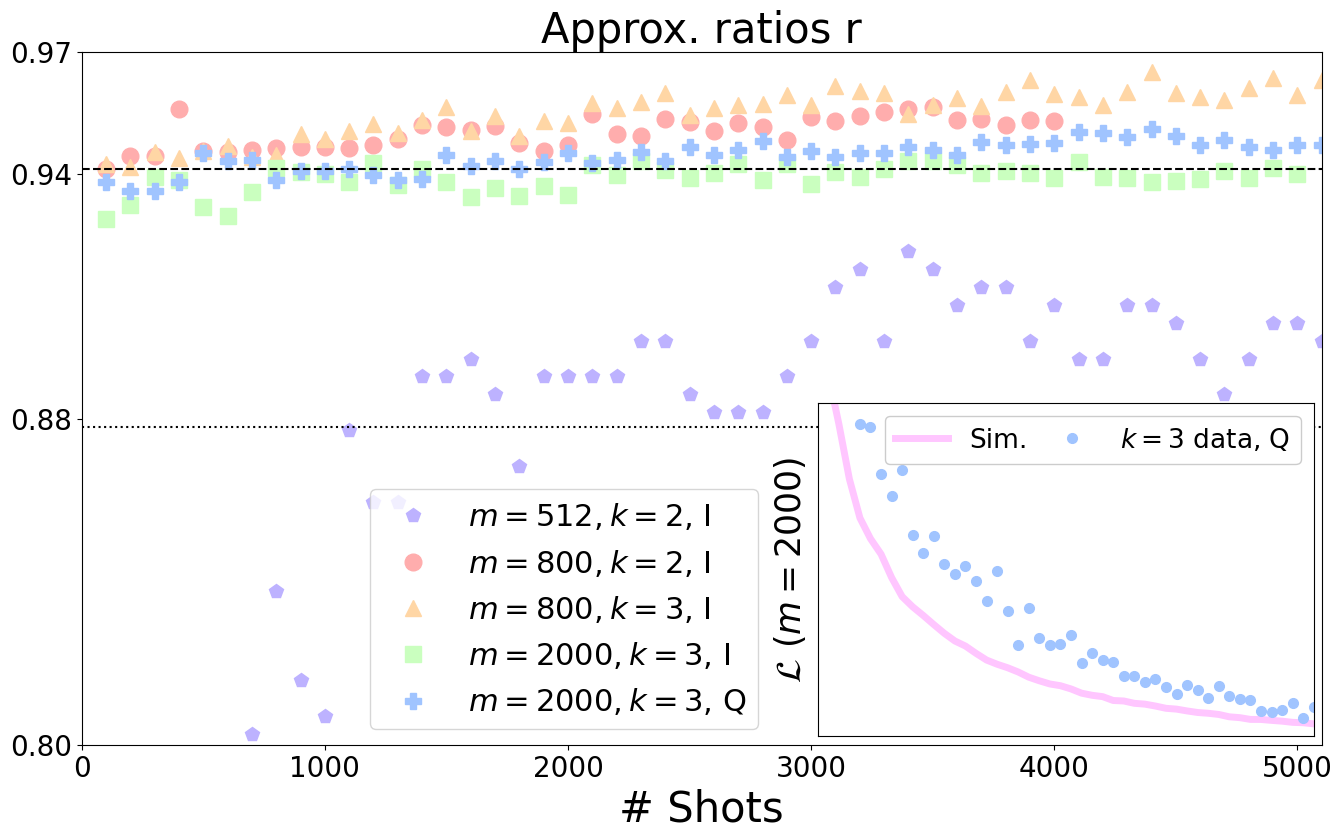

<Figure size 4800x2700 with 0 Axes>

In [34]:
from matplotlib.pyplot import figure

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')
colors = ["#ffadad", "#ffd6a5","#a0c4ff","#caffbf", "#9bf6ff", "#bdb2ff","#ffc6ff"]
markers = ["o", "^","s", "p", "P", "X", "D" ]
fig, axes = plt.subplots(figsize=(16, 9))
figure(figsize=(16, 9), dpi=300)

lns2 = axes.plot(list(range(100,4100,100)), np.array(cut_800_quadratic)/11624,'o',  label=r'$m = 800, k = 2$, I',markersize=12,  marker = markers[0], color=colors[0])
lns3 = axes.plot(list(range(100,7100,100)), np.array(cut_800_cubic)/11624,'o', markersize=12, label=r'$m = 800, k = 3$, I',marker = markers[1], color=colors[1] )
lns4 = axes.plot(list(range(100,5100,100)), np.array(cut_2000_cubic)/7687, 'o', label=r'$m = 2000, k = 3$, I',markersize=12, marker=markers[2], color=colors[3])
lns5 = axes.plot(list(range(100,7100,100)), np.array(cut_2000_cubic_quantinuum)/7687, 'o', label=r'$m = 2000, k = 3$, Q',markersize=12, marker=markers[4], color=colors[2])

lns1 = axes.plot(list(range(100,6100,100),), np.array(cut)/456, 'o', markersize=10,  label=r'$m = 512, k = 2$, I', marker=markers[3], color=colors[5])


axes.axhline( linestyle = 'dotted', y=0.878 ,color='black')
axes.axhline( linestyle = 'dashed', y=16/17 ,color='black')

axes.set_xlabel('# Shots', size = 30)
axes.set_ylim(0.8,0.97)
axes.set_xlim(0,5100)
axes.set_yticks([0.8, 0.88,0.94,  0.97])
axes.tick_params(labelsize = 20)
left, bottom, width, height = [0.585, 0.12, 0.31, 0.37]
ax2 = fig.add_axes([left, bottom, width, height])

lns6 = ax2.plot(list(range(100,4900,100)), np.array(noiseless_loss_2000), '-',markersize=10, label=r'Sim.', color=colors[6], linewidth=5.0)

lns7 = ax2.plot(list(range(100,7100,100)), np.array(loss_2000_quantinuum), 'o', label=r'$k = 3$ data, Q', markersize=7, color=colors[2])

ax2.set_ylim(-700,300)
ax2.set_xlim(100,4800)
ax2.set_ylabel(r'$\mathcal{L} \  (m = 2000)$', size=25)
ax2.yaxis.set_label_coords(-0.02, 0.5)
ax2.tick_params(labelsize = 8)
ax2.set_xticks([])
ax2.set_yticks([])
lns_inset = lns6+lns7
labs = [l.get_label() for l in lns_inset]

ax2.legend(lns_inset, labs,ncol=2, columnspacing=0.7, loc= 'upper right', bbox_to_anchor=(1, 1), prop={'size': 19}, framealpha = 1)
lns = lns1+lns2+lns3 +lns4 + lns5
axes.set_title('Approx. ratios r', size = 30)
labs = [l.get_label() for l in lns]
axes.legend(lns, labs, loc='lower left', bbox_to_anchor=(0.22, 0), prop={'size': 22})
fig.subplots_adjust(wspace=0, hspace=0.1)


fig.savefig('approx_ratio_experiment_horizontal.png',dpi=300, bbox_inches = "tight")

plt.show()

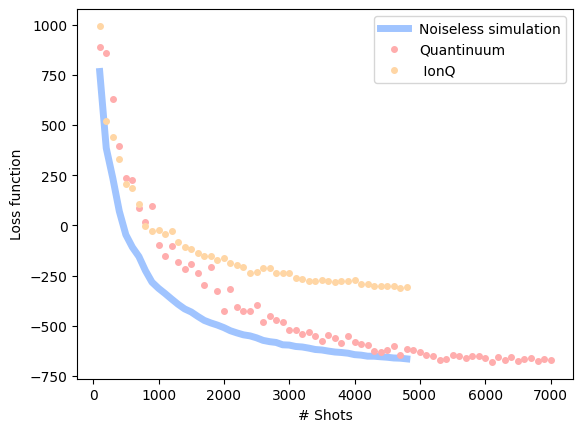

In [29]:
import matplotlib.pyplot as plt
colors = ["#ffadad", "#ffd6a5","#a0c4ff","#caffbf", "#9bf6ff", "#bdb2ff","#ffc6ff"]

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')
plt.plot(list(range(100,4900,100)), np.array(noiseless_loss_2000), '-',markersize=10, label=r'Noiseless simulation', color=colors[2], linewidth=5.0)

plt.plot(list(range(100,7100,100)), np.array(loss_2000_quantinuum), 'o', label=r'Quantinuum', markersize=4,
         color=colors[0])
plt.plot(list(range(100,4900,100)), np.array(loss_2000), 'o', label=r' IonQ', markersize=4, color=colors[1])

plt.xlabel('# Shots')
plt.ylabel('Loss function')
plt.legend()
plt.savefig('Quantinuum-Ionq-loss', dpi=300, bbox_inches="tight", format='png')
plt.show()

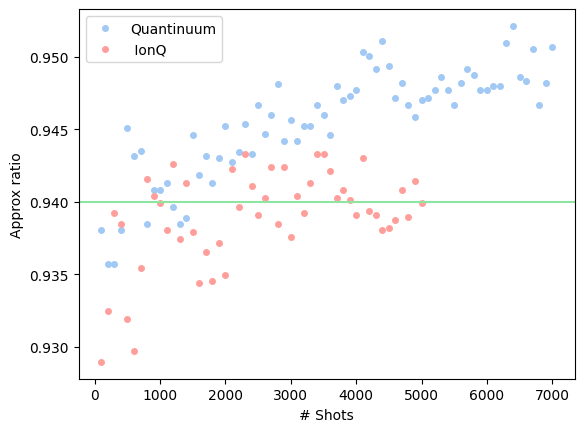

In [34]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')

plt.plot(list(range(100,7100,100)), np.array(cut_2000_cubic_quantinuum) / 7687, 'o', label=r'Quantinuum', markersize=4,
         color='#a1c9f4')
plt.plot(list(range(100,5100,100)), np.array(cut_2000_cubic) / 7687, 'o', label=r' IonQ', markersize=4,
         color='#ff9f9b')
plt.axhline(y=0.94, color='#8de5a1')
plt.xlabel('# Shots')
plt.ylabel('Approx ratio')
plt.legend()
plt.savefig('Quantinuum-Ionq', dpi=300, bbox_inches="tight", format='png')
plt.show()
